In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization
from math import ceil
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
import random

import gc; gc.collect()

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

# Read Log File

In [2]:
df=pd.read_csv('./data/data/driving_log.csv')

In [3]:

df=df[(df["center"].str.contains("2016")) | (df["center"].str.contains("2020_09_21")) ]

In [4]:
#df=pd.concat([df[df["center"].str.contains("2020_09_19_22_14")],df[df["center"].str.contains("2020_09_19_22_15")],df[df["center"].str.contains("2020_09_19_22_16")]],axis=0)

<AxesSubplot:>

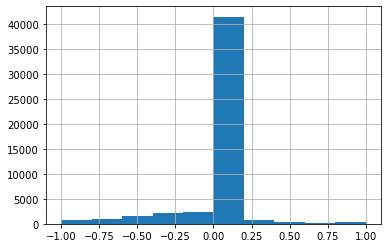

In [5]:
df['steering'].hist()

In [6]:
size=len(df[(df['steering']>0)])
size

3555

In [7]:
df[df['steering']==0][:size]

,center,left,right,steering,throttle,brake,speed
0,center_2016_12_01_13_30_48_287.jpg,left_2016_12_01_13_30_48_287.jpg,right_2016_12_01_13_30_48_287.jpg,0.0,0.000000,0.0,22.148290
1,center_2016_12_01_13_30_48_404.jpg,left_2016_12_01_13_30_48_404.jpg,right_2016_12_01_13_30_48_404.jpg,0.0,0.000000,0.0,21.879630
2,center_2016_12_01_13_31_12_937.jpg,left_2016_12_01_13_31_12_937.jpg,right_2016_12_01_13_31_12_937.jpg,0.0,0.000000,0.0,1.453011
3,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0,0.000000,0.0,1.438419
4,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0,0.000000,0.0,1.418236
...,...,...,...,...,...,...,...
6558,center_2016_12_01_13_44_11_946.jpg,left_2016_12_01_13_44_11_946.jpg,right_2016_12_01_13_44_11_946.jpg,0.0,0.985533,0.0,30.186630
6559,center_2016_12_01_13_44_12_046.jpg,left_2016_12_01_13_44_12_046.jpg,right_2016_12_01_13_44_12_046.jpg,0.0,0.985533,0.0,30.186630
6560,center_2016_12_01_13_44_12_147.jpg,left_2016_12_01_13_44_12_147.jpg,right_2016_12_01_13_44_12_147.jpg,0.0,0.985533,0.0,30.186630
6561,center_2016_12_01_13_44_12_249.jpg,left_2016_12_01_13_44_12_249.jpg,right_2016_12_01_13_44_12_249.jpg,0.0,0.985533,0.0,30.186630


In [8]:
newdf=pd.concat([df[df['steering']==0][:int(size)],df[(df['steering']>0) & (df['steering']<0.2)],df[(df['steering']<0) & (df['steering']>-0.2)][:int(size)],df[ (df['steering']<-0.2)][:int(size)],df[ (df['steering']>0.2)]],axis=0)

In [9]:
#newdf=pd.concat([df[(df['steering']>0) & (df['steering']<0.2)],df[(df['steering']<0) & (df['steering']>-0.2)],df[ (df['steering']<-0.2)],df[ (df['steering']>0.2)]],axis=0)

<AxesSubplot:>

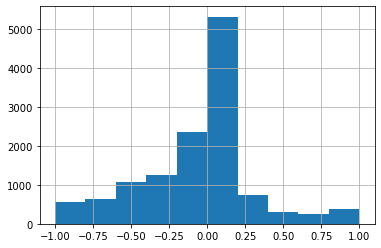

In [10]:
newdf['steering'].hist()

In [11]:
newdf[0:10]

,center,left,right,steering,throttle,brake,speed
0,center_2016_12_01_13_30_48_287.jpg,left_2016_12_01_13_30_48_287.jpg,right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,center_2016_12_01_13_30_48_404.jpg,left_2016_12_01_13_30_48_404.jpg,right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,center_2016_12_01_13_31_12_937.jpg,left_2016_12_01_13_31_12_937.jpg,right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
5,center_2016_12_01_13_31_13_279.jpg,left_2016_12_01_13_31_13_279.jpg,right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
6,center_2016_12_01_13_31_13_381.jpg,left_2016_12_01_13_31_13_381.jpg,right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
7,center_2016_12_01_13_31_13_482.jpg,left_2016_12_01_13_31_13_482.jpg,right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934
8,center_2016_12_01_13_31_13_584.jpg,left_2016_12_01_13_31_13_584.jpg,right_2016_12_01_13_31_13_584.jpg,0.0,0.0,0.0,1.362115
9,center_2016_12_01_13_31_13_686.jpg,left_2016_12_01_13_31_13_686.jpg,right_2016_12_01_13_31_13_686.jpg,0.0,0.0,0.0,1.348435


In [12]:
def bright(image, low, high):
    value = random.uniform(low, high)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image = np.array(image, dtype = np.float64)
    image[:,:,1] = image[:,:,1]*value
    image[:,:,1][image[:,:,1]>255]  = 255
    image[:,:,2] = image[:,:,2]*value 
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return image

In [13]:
def resize_(image, h, w):
    image = cv2.resize(image, (h, w), cv2.INTER_CUBIC)
    return image

In [14]:
def shift(image, index=0.0):
    
    index = random.uniform(-index, index)
    h, weight = image.shape[:2]
    dev = weight*index
    if index > 0:
        image = image[:, :int(weight-dev), :]
    if index < 0:
        image = image[:, int(-1*dev):, :]
    image = resize_(image, 120, 60)
    return image

In [15]:
import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            #print(batch_samples)

            images = []
            angles = []
            for i,batch_sample in batch_samples.iterrows():
                name = '.\\data\\data\\IMG\\'+batch_sample['center'].split('/')[-1]
                l_name= '.\\data\\data\\IMG\\'+batch_sample['left'].split('/')[-1]
                r_name='.\\data\\data\\IMG\\'+ batch_sample['right'].split('/')[-1]
                
                #print(name)
                                
                center_image = cv2.imread(name)
                center_image =center_image[50:135,:,:]
                center_image=cv2.resize(center_image,(120,60))
                
                if center_image is not None:
                
                    l_image=cv2.imread(l_name)
                    r_image=cv2.imread(r_name)
                    


                    
                    center_angle = float(batch_sample['steering'])
                    
                    images.append(center_image)
                    angles.append(center_angle)
                
                    center_image = cv2.cvtColor(center_image, cv2.COLOR_RGB2YUV)
                    center_image= cv2.GaussianBlur(center_image,  (3, 3), 0)
                
                
                    images.append(center_image)
                    angles.append(center_angle)
                    
                    images.append(shift(center_image,0.1))
                    angles.append(center_angle)
                    
                    images.append(bright(center_image, 0.5, 3))
                    angles.append(center_angle)
                    
                    #noisy= random_noise(center_image)
                    #images.append(noisy)
                    #angles.append(center_angle)
                    
                
                    image_flipped = np.fliplr(center_image)
                    measurement_flipped = -center_angle
                
                    images.append(image_flipped)
                    angles.append(measurement_flipped)
                    
                    if l_image is not None:
                        if r_image is not None:
                            l_image =l_image[50:135,:,:]
                            r_image =r_image[50:135,:,:] 
                            l_image=cv2.resize(l_image,(120,60))
                            r_image=cv2.resize(r_image,(120,60))
                            
                #transform = AffineTransform(translation=(-200,0))  # (-200,0) are x and y coordinate, change it see the effect
                #warp_image = warp(center_image,transform, mode="wrap")
                #images.append(warp_image)
                #angles.append(center_angle)

                            l_angle=center_angle+0.20
                            r_angle=center_angle-0.20
                            l_image_ = cv2.cvtColor(l_image, cv2.COLOR_RGB2YUV)
                            l_image_= cv2.GaussianBlur(l_image_,  (3, 3), 0)




                            image_flipped = np.fliplr(l_image_)
                            measurement_flipped = -l_angle

                            images.append(image_flipped)
                            angles.append(measurement_flipped)

                            images.append(l_image_)
                            angles.append(l_angle)
                            
                            images.append(l_image)
                            angles.append(l_angle)

                            r_image_ = cv2.cvtColor(r_image, cv2.COLOR_RGB2YUV)
                            r_image_= cv2.GaussianBlur(r_image_,  (3, 3), 0)            
                            #
                            images.append(r_image_)
                            angles.append(r_angle)
                            
                            images.append(r_image)
                            angles.append(r_angle)




                            image_flipped = np.fliplr(r_image_)
                            measurement_flipped = -r_angle

                            images.append(image_flipped)
                            angles.append(measurement_flipped)            


                    #images.extend([center_image,l_image,r_image])
                    #angles.extend([center_angle,l_angle,r_angle])

            # trim image to only see section with road

            X_train =  np.asarray(images)
            y_train =  np.asarray(angles)
            #if (offset%5000==0):
            #    for i in X_train:
            #        plt.imshow(i)
            #        plt.show()
            #        print(i.shape)
            #    print(y_train)

            yield  (X_train, y_train)




In [16]:

ch, row, col = 3, 80, 320  # Trimmed image format


from keras.models import load_model
from keras.optimizers import Adam

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(60,120,3)))
#model.add(Cropping2D(cropping=((50,20), (0,0))))
model.add(Conv2D(24, (5, 5),  activation = 'elu'))
model.add(Conv2D(36, (5, 5),  activation = 'elu'))
model.add(Conv2D(48, (5, 5),  activation = 'elu'))
model.add(Conv2D(64, (3, 3), activation = 'elu'))
model.add(Conv2D(64, (3, 3), activation = 'elu'))



from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.0001)
early = EarlyStopping(monitor='val_loss',  patience=4, 
                      verbose=2, mode='auto',
                      restore_best_weights=True)

# FC
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss = 'mse', optimizer = adam)


#model=load_model('model.h5')

In [ ]:
for i in range(0,1000):
    gc.collect()
    
    df=df.sample(frac=1)
    
    newdf=pd.concat([df[df['steering']==0][:int(size)],df[(df['steering']>0) & (df['steering']<0.2)],df[(df['steering']<0) & (df['steering']>-0.2)][:int(size)],df[ (df['steering']<-0.2)][:int(size)],df[ (df['steering']>0.2)]],axis=0)

    newdf=newdf.sample(frac=1)

    from sklearn.model_selection import train_test_split
    train_samples, validation_samples = train_test_split(newdf, test_size=0.2)



    # Set our batch size
    batch_size=2

    # compile and train the model using the generator function
    train_generator = generator(train_samples, batch_size=batch_size)
    validation_generator = generator(validation_samples, batch_size=batch_size)




    model.fit_generator(train_generator,
                steps_per_epoch=ceil(len(train_samples)/batch_size), 
                validation_data=validation_generator,
                validation_steps=ceil(len(validation_samples)/batch_size), 
                epochs=200, verbose=1,callbacks=[checkpoint,early,reduce_lr])

    model.save('model.h5')



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
5167/5167 [==============================] - ETA: 0s - loss: 9.2694
Epoch 00001: val_loss improved from inf to 0.12697, saving model to model.h5
5167/5167 [==============================] - 2149s 416ms/step - loss: 9.2694 - val_loss: 0.1270 - lr: 0.0010
Epoch 2/200
  31/5167 [..............................] - ETA: 32:19 - loss: 0.1664